In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from ast import literal_eval
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/interim/part_c/train_flows_labelled.csv')
print(data.shape)
data.head()

(2506580, 24)


,flow_key,lst_timestamp,qt_pkt,qt_pkt_tcp,qt_pkt_udp,qt_pkt_icmp,qt_pkt_ip,qt_prtcl,qt_src_prt,qt_dst_prt,...,qt_ack_fl,qt_urg_fl,qt_ecn_fl,qt_cwr_fl,avg_hdr_len,avg_pkt_len,frq_pkt,avg_ttl,tm_dur_s,label
0,"('192.168.50.7', '74.208.236.171')",2018-12-01 13:17:32,100,100,0,0,0,1,12,1,...,76,0,0,0,20.0,143.620000,50.0,128.0,2.0,BENIGN
1,"('74.208.236.171', '192.168.50.7')",2018-12-01 13:17:32,100,100,0,0,0,1,1,12,...,100,0,0,0,20.0,917.720000,50.0,54.0,2.0,BENIGN
2,"('74.208.236.171', '192.168.50.7')",2018-12-01 13:17:32,200,200,0,0,0,1,1,12,...,200,0,0,0,20.0,1390.710000,100.0,54.0,2.0,BENIGN
3,"('192.168.50.7', '74.208.236.171')",2018-12-01 13:17:32,200,200,0,0,0,1,15,1,...,170,0,0,0,20.0,119.380000,100.0,128.0,2.0,BENIGN
4,"('74.208.236.171', '192.168.50.7')",2018-12-01 13:17:32,300,300,0,0,0,1,1,15,...,300,0,0,0,20.0,1533.166667,150.0,54.0,2.0,BENIGN


In [3]:
X = data.iloc[:, 2:-1]
y = (data.label != 'BENIGN') * 1

In [4]:
X.head()

,qt_pkt,qt_pkt_tcp,qt_pkt_udp,qt_pkt_icmp,qt_pkt_ip,qt_prtcl,qt_src_prt,qt_dst_prt,qt_fin_fl,qt_syn_fl,...,qt_psh_fl,qt_ack_fl,qt_urg_fl,qt_ecn_fl,qt_cwr_fl,avg_hdr_len,avg_pkt_len,frq_pkt,avg_ttl,tm_dur_s
0,100,100,0,0,0,1,12,1,14,24,...,22,76,0,0,0,20.0,143.620000,50.0,128.0,2.0
1,100,100,0,0,0,1,1,12,14,24,...,8,100,0,0,0,20.0,917.720000,50.0,54.0,2.0
2,200,200,0,0,0,1,1,12,14,24,...,16,200,0,0,0,20.0,1390.710000,100.0,54.0,2.0
3,200,200,0,0,0,1,15,1,16,30,...,32,170,0,0,0,20.0,119.380000,100.0,128.0,2.0
4,300,300,0,0,0,1,1,15,14,30,...,24,300,0,0,0,20.0,1533.166667,150.0,54.0,2.0


In [5]:
y.value_counts()

1    2500201
0       6379
Name: label, dtype: int64

In [6]:
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## Decision Tree

In [7]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 6)],
    'min_samples_leaf': [10 ** i for i in range(5)]
}

In [8]:
gscv = GridSearchCV(estimator=DecisionTreeClassifier(),
                    scoring='f1_micro',
                    param_grid=param_grid,
                    cv=kf, 
                    n_jobs=-1,
                    verbose=2)

In [9]:
gscv.fit(X, y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 10, 100, 1000, 10000]},
             scoring='f1_micro', verbose=2)

In [10]:
pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
45,13.991243,0.392227,0.221108,0.041471,entropy,5,1,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",1.000000,1.000000,...,1.000000,0.999996,1.000000,1.000000,0.999996,1.000000,1.000000,0.999999,0.000002,1
46,14.127556,0.415908,0.235978,0.038227,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.999996,0.999992,...,0.999992,0.999988,0.999996,0.999996,0.999988,0.999980,0.999992,0.999992,0.000005,2
40,14.449442,0.285504,0.223450,0.043228,entropy,4,1,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.999988,0.999988,...,1.000000,0.999980,0.999988,1.000000,0.999996,0.999980,0.999988,0.999990,0.000007,3
41,14.128932,0.367203,0.216304,0.031555,entropy,4,10,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.999984,0.999980,...,0.999992,0.999976,0.999984,0.999996,0.999992,0.999964,0.999984,0.999985,0.000009,4
20,18.133002,0.798859,0.233455,0.051430,gini,5,1,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.999984,0.999992,...,0.999992,0.999976,0.999988,0.999988,0.999984,0.999972,0.999980,0.999985,0.000007,5
21,17.701788,0.576239,0.241286,0.052181,gini,5,10,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.999984,0.999984,...,0.999984,0.999972,0.999984,0.999980,0.999976,0.999960,0.999976,0.999979,0.000008,6
35,11.534811,0.418420,0.229296,0.022091,entropy,3,1,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.999976,0.999988,...,0.999996,0.999972,0.999968,0.999984,0.999980,0.999960,0.999968,0.999979,0.000012,7
47,14.475273,0.419827,0.222309,0.034955,entropy,5,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.999976,0.999980,...,0.999988,0.999972,0.999964,0.999980,0.999976,0.999948,0.999968,0.999975,0.000012,8
36,11.378814,0.281985,0.216789,0.035261,entropy,3,10,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.999976,0.999980,...,0.999988,0.999972,0.999964,0.999980,0.999976,0.999948,0.999968,0.999975,0.000012,8
42,14.220200,0.508059,0.254098,0.048477,entropy,4,100,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.999976,0.999980,...,0.999988,0.999972,0.999964,0.999980,0.999976,0.999948,0.999968,0.999975,0.000012,8


In [11]:
gscv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5)

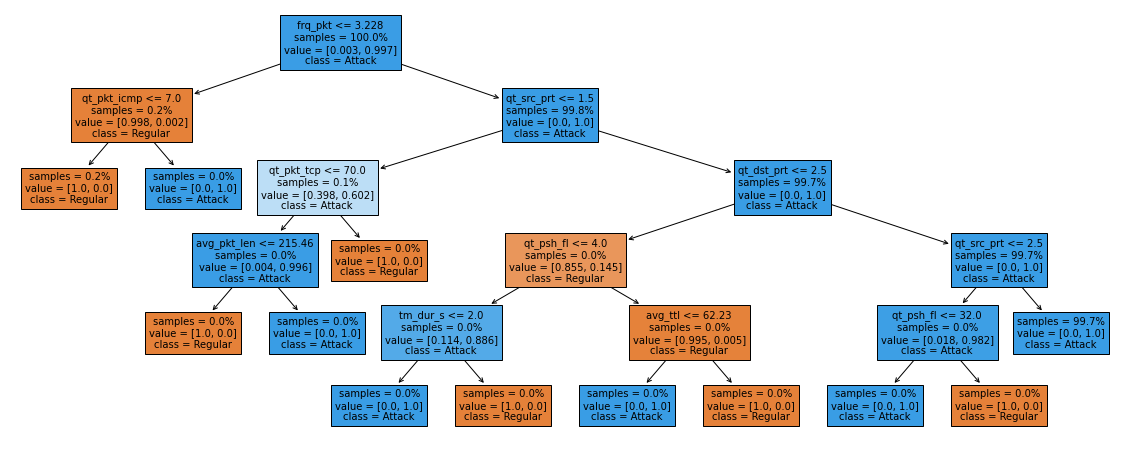

In [12]:
plt.figure(figsize=(20, 8))
plot_tree(gscv.best_estimator_, 
          feature_names=X.columns, 
          fontsize=10, 
          filled=True,
          proportion=True,
          class_names=['Regular', 'Attack'],
          impurity=False)
;
plt.savefig('../figures/binary_model.png')

I will try also with a simpler model, since there is not a relevant score difference.

In [13]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=100)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=100)

''

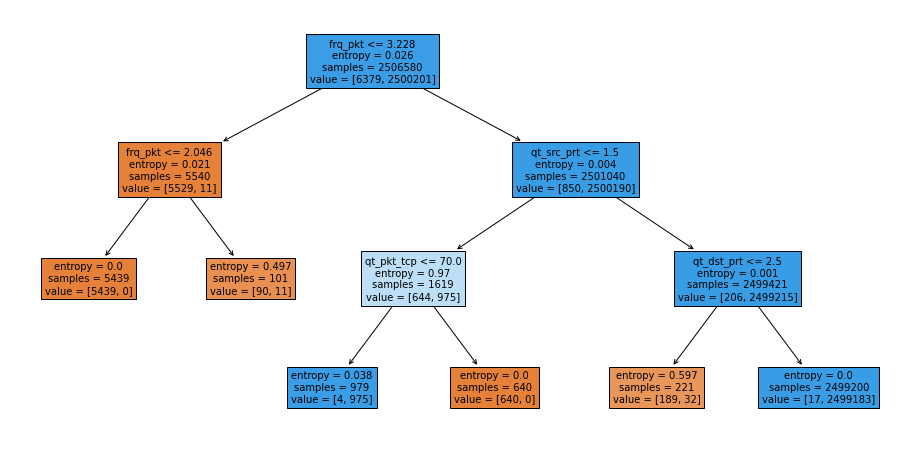

In [14]:
plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=X.columns, fontsize=10, filled=True)
;

In [15]:
data_test = pd.read_csv('../data/interim/part_c/test_flows_labelled.csv')
print(data_test.shape)
data_test.head()

(612267, 24)


,flow_key,lst_timestamp,qt_pkt,qt_pkt_tcp,qt_pkt_udp,qt_pkt_icmp,qt_pkt_ip,qt_prtcl,qt_src_prt,qt_dst_prt,...,qt_ack_fl,qt_urg_fl,qt_ecn_fl,qt_cwr_fl,avg_hdr_len,avg_pkt_len,frq_pkt,avg_ttl,tm_dur_s,label
0,"('172.16.0.5', '192.168.50.4')",2018-11-03 12:20:21,100,58,0,42,0,2,6,8,...,34,0,0,0,20.0,96.06,0.819672,99.82,122.0,Portmap
1,"('192.168.50.4', '172.16.0.5')",2018-11-03 12:20:32,100,54,0,46,0,2,8,6,...,54,0,0,0,20.0,113.10,0.751880,64.00,133.0,Portmap
2,"('192.168.50.8', '4.2.2.4')",2018-11-03 12:20:41,100,0,100,0,0,1,50,1,...,0,0,0,0,20.0,81.06,9.090909,128.00,11.0,BENIGN
3,"('4.2.2.4', '192.168.50.8')",2018-11-03 12:20:41,100,0,100,0,0,1,1,50,...,0,0,0,0,20.0,130.72,9.090909,56.00,11.0,BENIGN
4,"('172.217.9.226', '192.168.50.8')",2018-11-03 12:20:41,100,100,0,0,0,1,2,5,...,100,0,0,0,20.0,389.46,100.000000,53.00,1.0,BENIGN


In [16]:
X_test = data_test.iloc[:, 2:-1]
y_test = (data_test.label != 'BENIGN') * 1

## Cohen Kappa

### Best model

In [17]:
y_train_pred = gscv.predict(X)
y_test_pred = gscv.predict(X_test)

ck_train = cohen_kappa_score(y_train_pred, y)
ck_test = cohen_kappa_score(y_test_pred, y_test)

print(f'Cohen Kappa on train: {ck_train}')
print(f'Cohen Kappa on test: {ck_test}')

Cohen Kappa on train: 1.0
Cohen Kappa on test: 0.9998861217530904


### Smaller tree

In [18]:
y_train_pred = clf.predict(X)
y_test_pred = clf.predict(X_test)

ck_train = cohen_kappa_score(y_train_pred, y)
ck_test = cohen_kappa_score(y_test_pred, y_test)

print(f'Cohen Kappa on train: {ck_train}')
print(f'Cohen Kappa on test: {ck_test}')

Cohen Kappa on train: 0.9949793762846165
Cohen Kappa on test: 0.9604660454101606


## Confusion Matrix

In [36]:
y_train_pred = gscv.predict(X)
y_test_pred = gscv.predict(X_test)

### Train

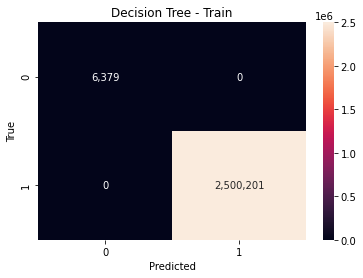

In [38]:
sns.heatmap(confusion_matrix(y, y_train_pred), annot=True, fmt=',')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Decision Tree - Train')
plt.savefig('../plots/part_c/decision_tree_train_conf_mat.png')

### Test

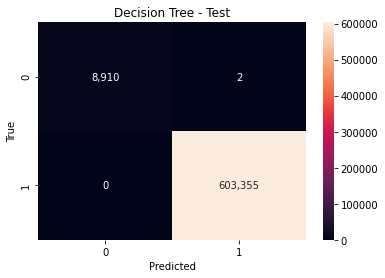

In [39]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=',')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Decision Tree - Test')
plt.savefig('../plots/part_c/decision_tree_test_conf_mat.png')

In [23]:
data_test[y_test != y_test_pred]

,flow_key,lst_timestamp,qt_pkt,qt_pkt_tcp,qt_pkt_udp,qt_pkt_icmp,qt_pkt_ip,qt_prtcl,qt_src_prt,qt_dst_prt,...,qt_ack_fl,qt_urg_fl,qt_ecn_fl,qt_cwr_fl,avg_hdr_len,avg_pkt_len,frq_pkt,avg_ttl,tm_dur_s,label
80,"('172.217.6.194', '192.168.50.6')",2018-11-03 12:29:52,100,100,0,0,0,1,2,2,...,100,0,0,0,20.0,1068.28,50.0,53.00,2.0,BENIGN
606835,"('104.239.227.128', '192.168.50.9')",2018-11-03 15:23:50,100,100,0,0,0,1,2,14,...,100,0,0,0,20.0,1105.28,100.0,50.42,0.0,BENIGN


## Logistic Regression

In [28]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 3, 10),
}

In [29]:
gscv_lr = GridSearchCV(estimator=LogisticRegression(),
                       scoring='f1_micro',
                       param_grid=param_grid,
                       cv=kf, 
                       n_jobs=-1,
                       verbose=2)

In [30]:
gscv_lr.fit(X, y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.6min finished
/home/caiolmart/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 5.99484250e-04, 3.59381366e-03, 2.15443469e-02,
       1.29154967e-01, 7.74263683e-01, 4.64158883e+00, 2.78255940e+01,
       1.66810054e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_micro', verbose=2)

In [31]:
pd.DataFrame(gscv_lr.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
25,95.896455,4.801579,0.275827,0.041688,166.81,l2,"{'C': 166.81005372000593, 'penalty': 'l2'}",0.999992,0.999992,1.000000,0.999988,0.999984,0.999996,0.999984,0.999984,0.999992,0.999988,0.999990,0.000005,1
10,94.299964,4.785941,0.221498,0.032813,0.0215443,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.999992,0.999996,1.000000,0.999992,0.999980,0.999996,0.999980,0.999984,0.999988,0.999988,0.999990,0.000006,2
13,96.173692,6.111322,0.225493,0.015045,0.129155,l2,"{'C': 0.1291549665014884, 'penalty': 'l2'}",0.999988,0.999996,1.000000,0.999988,0.999980,0.999988,0.999984,0.999988,0.999988,0.999988,0.999989,0.000005,3
7,93.779192,3.962782,0.286621,0.069036,0.00359381,l2,"{'C': 0.003593813663804626, 'penalty': 'l2'}",0.999992,0.999992,1.000000,0.999992,0.999976,0.999992,0.999984,0.999984,0.999988,0.999988,0.999989,0.000006,3
16,93.464069,4.236563,0.210034,0.014349,0.774264,l2,"{'C': 0.774263682681127, 'penalty': 'l2'}",0.999988,0.999992,1.000000,0.999980,0.999980,0.999996,0.999988,0.999988,0.999988,0.999988,0.999989,0.000006,3
22,98.739280,6.356297,0.210135,0.015967,27.8256,l2,"{'C': 27.825594022071257, 'penalty': 'l2'}",0.999992,1.000000,1.000000,0.999972,0.999980,0.999992,0.999980,0.999988,0.999984,0.999988,0.999988,0.000008,6
28,76.680262,21.698439,0.124665,0.053349,1000,l2,"{'C': 1000.0, 'penalty': 'l2'}",0.999992,0.999996,1.000000,0.999976,0.999980,0.999992,0.999980,0.999984,0.999984,0.999988,0.999987,0.000007,7
19,94.562160,4.142089,0.205866,0.024146,4.64159,l2,"{'C': 4.641588833612782, 'penalty': 'l2'}",0.999992,0.999984,1.000000,0.999976,0.999976,0.999992,0.999980,0.999988,0.999984,0.999984,0.999986,0.000007,8
4,90.390660,2.048074,0.455479,0.120636,0.000599484,l2,"{'C': 0.0005994842503189409, 'penalty': 'l2'}",0.999992,0.999980,1.000000,0.999980,0.999976,0.999984,0.999968,0.999972,0.999972,0.999976,0.999980,0.000009,9
1,93.348005,4.462474,0.383726,0.075680,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.999972,0.999960,0.999984,0.999976,0.999968,0.999968,0.999948,0.999960,0.999964,0.999964,0.999966,0.000009,10


In [40]:
y_train_pred = gscv_lr.predict(X)
y_test_pred = gscv_lr.predict(X_test)

ck_train = cohen_kappa_score(y_train_pred, y)
ck_test = cohen_kappa_score(y_test_pred, y_test)

print(f'Cohen Kappa on train: {ck_train}')
print(f'Cohen Kappa on test: {ck_test}')

Cohen Kappa on train: 0.9977173692274927
Cohen Kappa on test: 0.9599527653361968


### Train

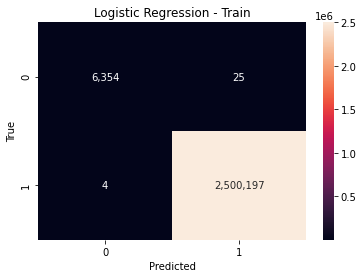

In [41]:
sns.heatmap(confusion_matrix(y, y_train_pred), annot=True, fmt=',')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Logistic Regression - Train')
plt.savefig('../plots/part_c/logistic_regression_train_conf_mat.png')

### Test

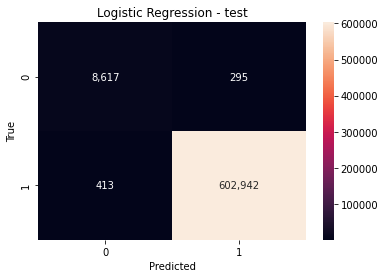

In [42]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=',')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Logistic Regression - test')
plt.savefig('../plots/part_c/logistic_regression_test_conf_mat.png')